(glue)=

# Inserting variables into pages with `glue`

You often wish to run analyses in one notebook and insert them into your
documents text elsewhere. For example, if you'd like to include a figure,
or if you want to cite a statistic that you have run.

The **`glue` submodule** allows you to add a key to variables in a notebook,
then display those variables in your book by referencing the key.

This page describes how to add keys to variables in notebooks, and how to insert them
into your book's content in a variety of ways.

(glue/gluing)=

## Gluing variables in your notebook

You can use `myst_nb.glue()` to assign value of a variable to
a key of your choice. `glue` will store all of the information that is normally used to **display**
that variable (ie, whatever happens when you display the variable by putting it at the end of a cell).
Choose a key that you will remember, as you will use it later.

The following code glues a variable inside the notebook:

In [1]:
from myst_nb import glue
a = "my variable!"
glue("my_variable", a)

'my variable!'

You can then insert it into your text like so: {glu:text}`my_variable`.

That was accomplished with the following code: `` {glu:text}`my_variable` ``.

### Gluing numbers, plots, and tables

You can glue anything in your notebook and display it later with `{glu:}`. Here
we'll show how to glue and paste **numbers and images**. We'll simulate some
data and run a simple bootstrap on it. We'll hide most of this process below,
to focus on the glueing part.

In [2]:
# Simulate some data and bootstrap the mean of the data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

n_points = 10000
n_boots = 1000
mean, sd = (3, .2)
data = sd*np.random.randn(n_points) + mean
bootstrap_indices = np.random.randint(0, n_points, n_points*n_boots).reshape((n_boots, n_points))

In the cell below, `data` contains our data, and `bootstrap_indices` is a collection of sample indices in each bootstrap. Below we'll calculate a few statistics of interest, and
**`glue()`** them into the notebook.

In [3]:
# Calculate the mean of a bunch of random samples
means = data[bootstrap_indices].mean(0)
# Calcualte the 95% confidence interval for the mean
clo, chi = np.percentile(means, [2.5, 97.5])

# Store the values in our notebook
glue("boot_mean", means.mean())
glue("boot_clo", clo)
glue("boot_chi", chi)

3.001206945957487

2.988751181750824

3.0135614326295035

By default, `glue` will display the value of the variable you are gluing. This
is useful for sanity-checking its value at glue-time. If you'd like to **prevent display**,
use the `display=False` option. Note that below, we also *overwrite* the value of
`boot_chi` (but using the same value):

In [4]:
glue("boot_chi_notdisplayed", chi, display=False)

You can also glue visualizations, such as matplotlib figures (here we use `display=False` to ensure that the figure isn't plotted twice):

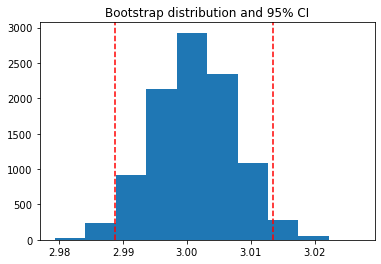

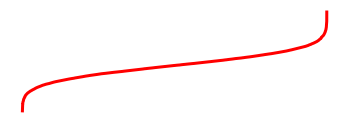

In [5]:
# Visualize the historgram with the intervals
fig, ax = plt.subplots()
ax.hist(means)
for ln in [clo, chi]:
    ax.axvline(ln, ls='--', c='r')
ax.set_title("Bootstrap distribution and 95% CI")

# And a wider figure to show a timeseries
fig2, ax = plt.subplots(figsize=(6, 2))
ax.plot(np.sort(means), lw=3, c='r')
ax.set_axis_off()

glue("boot_fig", fig, display=False)
glue("sorted_means_fig", fig2, display=False)

The same can be done for DataFrames (or other table-like objects) as well.

In [6]:
bootstrap_subsets = data[bootstrap_indices][:3, :5].T
df = pd.DataFrame(bootstrap_subsets, columns=["first", "second", "third"])
glue("df_tbl", df)

,first,second,third
0,3.159199,2.918999,3.086039
1,2.998375,3.263124,3.230380
2,2.820858,2.783518,3.273223
3,2.768669,3.074504,3.089464
4,2.893124,3.109417,3.274855


```{tip}
Since we are going to paste this figure into our document at a later point,
you may wish to remove the output here, using the `remove_output` tag
(see {ref}`use/removing`).
```

(glue/pasting)=

## Pasting glued variables into your page

Once you have glued variables into a notebook, you can then **paste**
those variables into your text in your book anywhere you like (even on other pages).
These variables can be pasted using one of the roles or directives in the `glu:` *family*.

### The `glu:any` role/directive

The simplest role and directive are `glu:any`,
which paste the glued output inline or as a block respectively,
with no additional formatting.
Simply add this:

````
```{glu:any} your-key
```
````

For example, we'll paste the plot we generated above with the following text:

````md
```{glu:any} boot_fig
```
````

Here's how it looks:

```{glu:any} boot_fig
```

Or we can paste inline objects like so:


```md
Inline text; {glu:any}`boot_mean`, and figure; {glu:any}`boot_fig`.
```

Inline text; {glu:any}`boot_mean`, and figure; {glu:any}`boot_fig`.

```{tip}
We recommend using wider, shorter figures when plotting in-line, with a ratio
around 6x2. For example, here's is an in-line figure of sorted means
from our bootstrap: {glu:any}`sorted_means_fig`.
It can be used to make a visual point that isn't too complex! For more
ideas, check out [how sparklines are used](https://en.wikipedia.org/wiki/Sparkline).
```

Next we'll cover some more specific pasting functionality, which gives you more
control over how the outputs look in your pages.

### The `glu:text` role

The `glu:text` role, is specific to text outputs.
For example, the following text:

```
The mean of the bootstrapped distribution was {glu:text}`boot_mean` (95% confidence interval {glu:text}`boot_clo`/{glu:text}`boot_chi`).
```

Is rendered as: 
The mean of the bootstrapped distribution was {glu:text}`boot_mean` (95% confidence interval {glu:text}`boot_clo`/{glu:text}`boot_chi`)

```{note}
`glu:text` only works with glued variables that contain a `text/plain` output.
```

With `glu:text` we can **add formatting to the output**.
This is particularly useful if you are displaying numbers and
want to round the results. To add formatting, use this pattern:

* `` {glu:text}`mykey:formatstring` ``

For example, the following: ``My rounded mean: {glu:text}`boot_mean:.2f` `` will be rendered like this: My rounded mean: {glu:text}`boot_mean:.2f` (95% CI: {glu:text}`boot_clo:.2f`/{glu:text}`boot_chi:.2f`).


### The `glu:figure` directive

With `glu:figure` you can apply more formatting to figure like objects,
such as giving them a caption and referencable label:

````md
```{glu:figure} boot_fig
:figwidth: 300px
:name: "fig-boot"

This is a **caption**, with an embedded `{glu:text}` element: {glu:text}`boot_mean:.2f`!
```
````

```{glu:figure} boot_fig
:figwidth: 300px
:name: "fig-boot"

This is a **caption**, with an embedded `{glu:text}` element: {glu:text}`boot_mean:.2f`!
```

```md
Here is a {ref}`reference to the figure <fig-boot>`
```

Here is a {ref}`reference to the figure <fig-boot>`

Here's a table:

````md
```{glu:figure} df_tbl
:figwidth: 300px
:name: "tbl:df"

A caption for a pandas table.
```

````
```{glu:figure} df_tbl
:figwidth: 300px
:name: "tbl:df"

A caption for a pandas table.
```

### The `glu:math` directive

The `glu:math` directive, is specific to latex math outputs
(glued variables that contain a `text/latex` mimetype),
and works similarly to the [sphinx math directive](https://www.sphinx-doc.org/en/1.8/usage/restructuredtext/directives.html#math).
For example:

In [7]:
import sympy as sym
f = sym.Function('f')
y = sym.Function('y')
n = sym.symbols(r'\alpha')
f = y(n)-2*y(n-1/sym.pi)-5*y(n-2)
glue("sym_eq", sym.rsolve(f,y(n),[1,4]))

(sqrt(5)*I)**\alpha*(1/2 - 2*sqrt(5)*I/5) + (-sqrt(5)*I)**\alpha*(1/2 + 2*sqrt(5)*I/5)

````md
Insert the equation here:

```{glu:math} sym_eq
:label: eq-sym
```

Which we reference as Equation {eq}`eq-sym`
````

Insert the equation here:

```{glu:math} sym_eq
:label: eq-sym
```

Which we reference as Equation {eq}`eq-sym`.

```{note}
`glu:math` only works with glued variables that contain a `text/latex` output.
```

### Pasting into tables

In addition to pasting blocks of outputs, or in-line with text, you can also paste directly
into tables. This allows you to compose complex collections of structured data using outputs
that were generated in other notebooks. For example the following table:

````md
| name                            |       plot                  | mean                      | ci                                                |
|:-------------------------------:|:---------------------------:|---------------------------|---------------------------------------------------|
| histogram and raw text          | {glu:any}`boot_fig`         | {glu:any}`boot_mean`      | {glu:any}`boot_clo`-{glu:any}`boot_chi`           |
| sorted means and formatted text | {glu:any}`sorted_means_fig` | {glu:text}`boot_mean:.3f` | {glu:text}`boot_clo:.3f`-{glu:text}`boot_chi:.3f` |
````

Results in:

| name                            |       plot                  | mean                      | ci                                                |
|:-------------------------------:|:---------------------------:|---------------------------|---------------------------------------------------|
| histogram and raw text          | {glu:any}`boot_fig`         | {glu:any}`boot_mean`      | {glu:any}`boot_clo`-{glu:any}`boot_chi`           |
| sorted means and formatted text | {glu:any}`sorted_means_fig` | {glu:text}`boot_mean:.3f` | {glu:text}`boot_clo:.3f`-{glu:text}`boot_chi:.3f` |